BloomTech Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

## Assignment

Complete these tasks for your assignment/project, and document your decisions.

- Choose your target. Which column in your tabular dataset will you predict?
- Is your problem regression or classification?
- How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- Begin to clean and explore your data.
- Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. Review requirements for your portfolio project on Canvas, and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

## Business Scenario

Lending Club is an American lending marketplace that connects investors with borrowers. Instead of a bank or financial institution, investors act as lenders to fund borrowers loans.

Investors want to lend money to people who show a profile 
of having a high probability of repayment. However, they face the challenge of predicting the risk of a borrower being unable to pay the loan back in full. They feel that the insights from existing data will help them in making data-driven decisions. So as data scientist, we will be building a model that can help in predicting whether a loan will not be paid back.

The dataset contains more than 9,500 loans with information about the borrower profile, loan structure and whether the loan was repaid. This data was extracted from [Kaggle - Loan Data](https://www.kaggle.com/datasets/itssuru/loan-data). 

### Data dictionary

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
|  0 | credit_policy     | 1 if the customer meets the credit underwriting criteria; 0 otherwise.                                                  |
|  1 | purpose           | The purpose of the loan.                                                                                                |
|  2 | int_rate          | The interest rate of the loan (more risky borrowers are assigned higher interest rates).                                |
|  3 | installment       | The monthly installments owed by the borrower if the loan is funded.                                                    |
|  4 | log_annual_inc    | The natural log of the self-reported annual income of the borrower.                                                     |
|  5 | dti               | The debt-to-income ratio of the borrower (amount of debt divided by annual income).                                     |
|  6 | fico              | The FICO credit score of the borrower.                                                                                  |
|  7 | days_with_cr_line | The number of days the borrower has had a credit line.                                                                  |
|  8 | revol_bal         | The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).                           |
|  9 | revol_util        | The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available). |
| 10 | inq_last_6mths    | The borrower's number of inquiries by creditors in the last 6 months.                                                   |
| 11 | delinq_2yrs       | The number of times the borrower had been 30+ days past due on a payment in the past 2 years.                           |
| 12 | pub_rec           | The borrower's number of derogatory public records.                                                                     |
| 13 | not_fully_paid    | 1 if the loan is not fully paid; 0 otherwise.   

In [1]:
# Import Libraries, Dataset

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from category_encoders import OrdinalEncoder, OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC # to fix imbalance data
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Path to dataset
DATA_PATH = '/Users/Yanin/Documents/BloomTech/Course/Sprint7/datasets/loan_data.csv'

## I. Wrangle Data

In [2]:
def wrangle(filepath):
    loans = pd.read_csv(filepath)
    
    # Replacing period in column names with underscore
    loans.columns = loans.columns.str.replace(".", "_")
    
    # Set data type of 'purpose' column as category
    loans['purpose'] = loans['purpose'].astype('category')
    
    return loans

In [3]:
# Read data
loans = wrangle(DATA_PATH)

# Check shape of data set and first 5 rows
print(loans.shape)
loans.head()

(9578, 14)


/var/folders/tj/1shzq07s7nq_rmtc7c_gkztm0000gp/T/ipykernel_52563/99989083.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  loans.columns = loans.columns.str.replace(".", "_")


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [4]:
# EDA
# Check data types, column names and non-null values
print('Total null values:', loans.isnull().sum().sum())
loans.info()

Total null values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   credit_policy      9578 non-null   int64   
 1   purpose            9578 non-null   category
 2   int_rate           9578 non-null   float64 
 3   installment        9578 non-null   float64 
 4   log_annual_inc     9578 non-null   float64 
 5   dti                9578 non-null   float64 
 6   fico               9578 non-null   int64   
 7   days_with_cr_line  9578 non-null   float64 
 8   revol_bal          9578 non-null   int64   
 9   revol_util         9578 non-null   float64 
 10  inq_last_6mths     9578 non-null   int64   
 11  delinq_2yrs        9578 non-null   int64   
 12  pub_rec            9578 non-null   int64   
 13  not_fully_paid     9578 non-null   int64   
dtypes: category(1), float64(6), int64(7)
memory usage: 982.6 KB


In [5]:
# Get summary statistics for numerical variables
loans.describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [6]:
# Summary statistics for categorical variables
loans.describe(include='category')

,purpose
count,9578
unique,7
top,debt_consolidation
freq,3957


In [7]:
# Unique values in column 'purpose'
loans['purpose'].value_counts()

debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: purpose, dtype: int64

In [8]:
# Check for duplicated records in the DataFrame
loans.duplicated().sum()

0

In [ ]:
# Quick Data Analysis Report
ProfileReport(loans, minimal= True).to_notebook_iframe()

---
From the Profile Report Summary we see that our dataset does not have high cardinality categorical variables.
Taking a look at our loan data set, we have a total of 14 columns and 9,578 rows. Out of these columns, we don't have any null values and we only have one categorical feature which is the column 'purpose'.
Since the data type of our 'purpose' column was originally 'object' we decided to set it as 'category'.

/var/folders/tj/1shzq07s7nq_rmtc7c_gkztm0000gp/T/ipykernel_52563/4213168032.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(loans.corr(), annot=True,


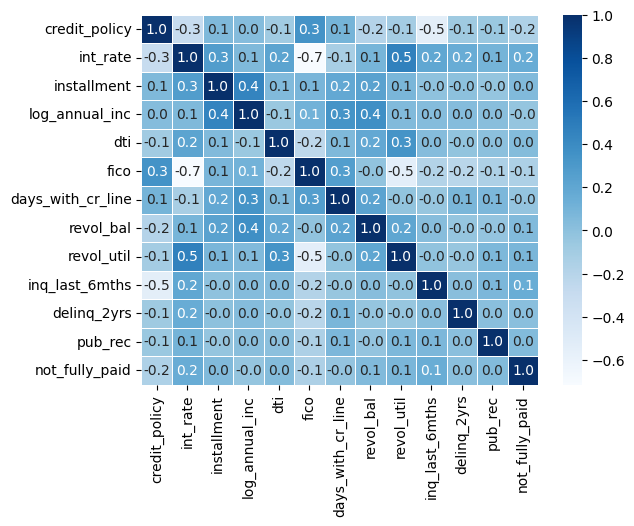

In [9]:
# Generate correlation matrix to understand the relationship between the different features
sns.heatmap(loans.corr(), annot=True,
            fmt=".1f", linewidth = 0.5, cmap = 'Blues');

In the correlation matrix, we can see a negative relationship between fico and interest rate. This means that the lower the fico scores, the higher the interest rate that Lendig Club assigns to the borrowers. 
Also, we see that annual income is slightly positively correlately with installments. The bigger the income, the bigger the installments to repay the loan.

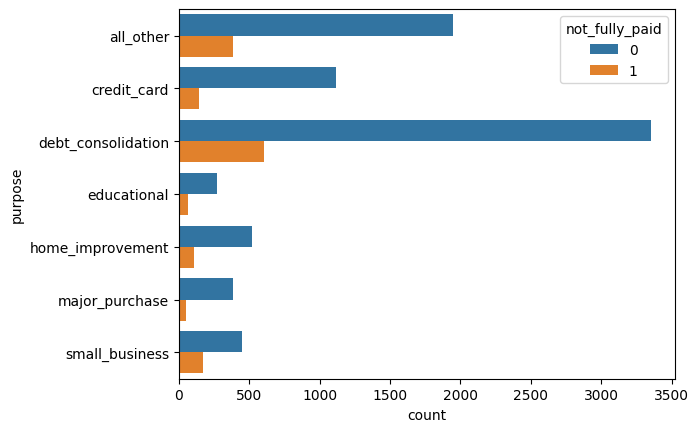

In [10]:
# Explore 'not.fully.paid' loan and the 'purpose' of the loan
sns.countplot(data=loans, y='purpose', hue='not_fully_paid');

Looking at the graph above we can conclude that most of the loans were taken with the purpose of debt consolidation. Many of the loans were completely paid back (0) and a few of them were not fully paid (1). Notice here that we encountered what is known as class imbalance: there are fewer examples of loans not fully paid. 

### Classification Task

We want to help the investors make a decision on whether to lend money to a potential borrower based on their capability to repay. The goal of this classification task is to accurately identify and predict whether a loan will not be paid back rather than if a loan is paid back. We will use the 'not.fully.paid' feature as our target variable. 

### Finding Outliers

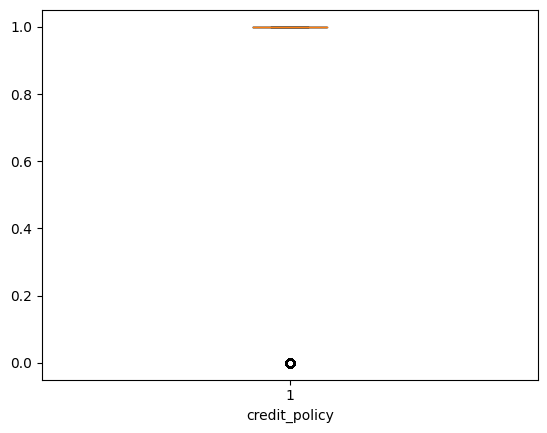

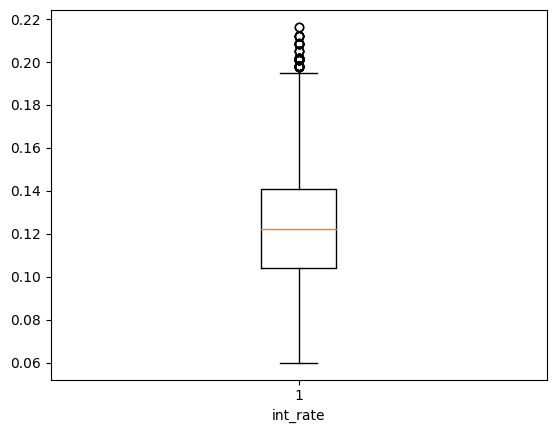

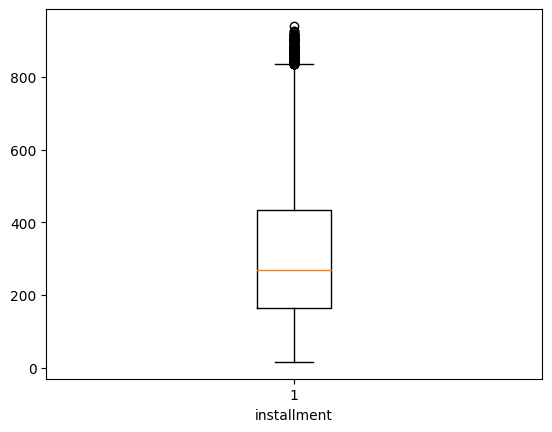

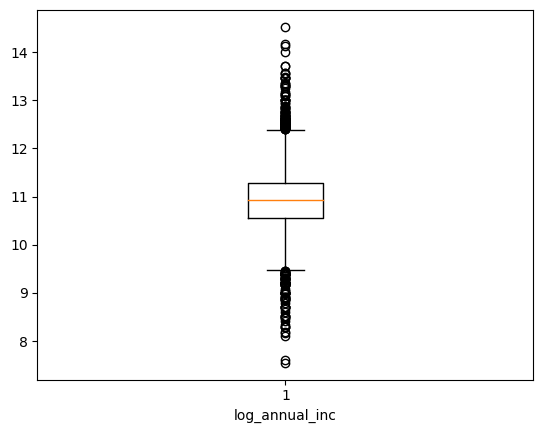

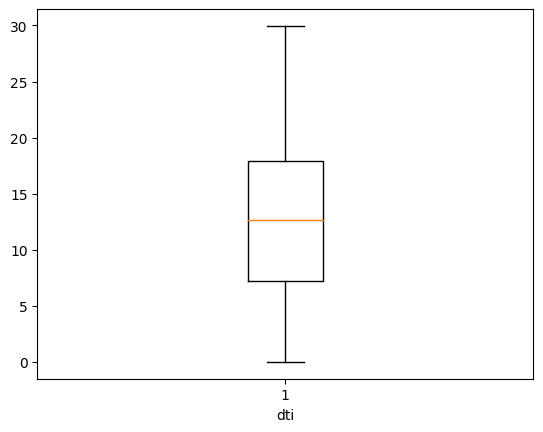

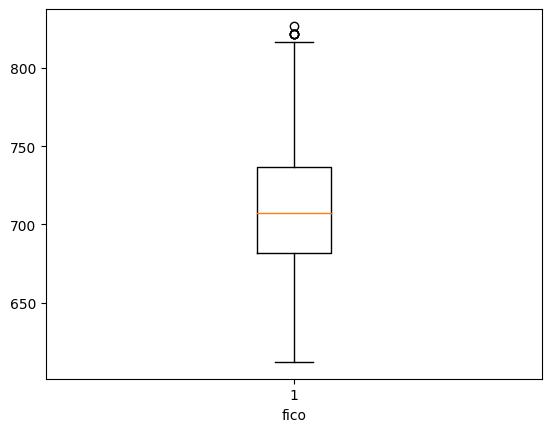

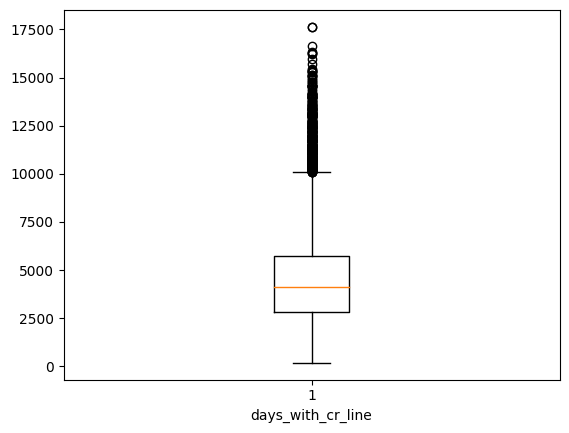

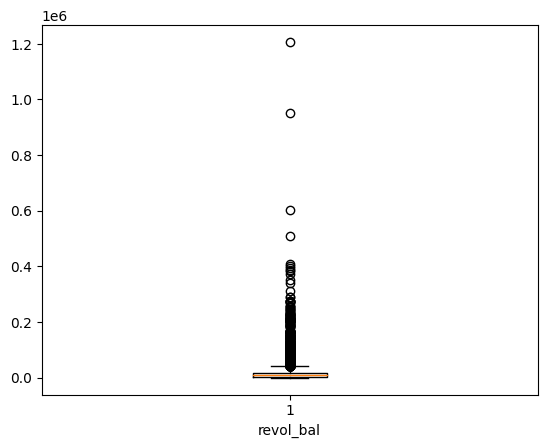

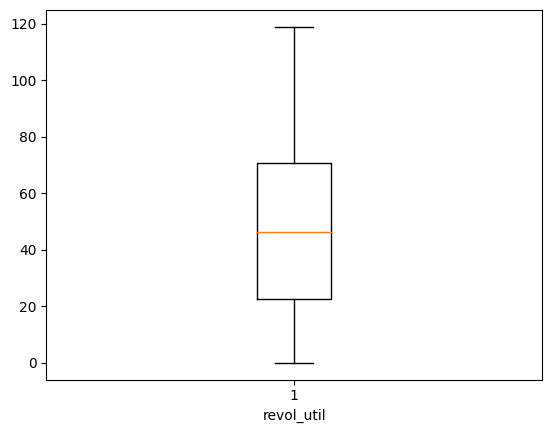

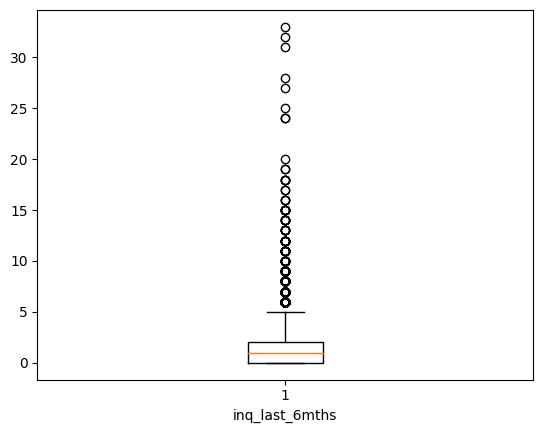

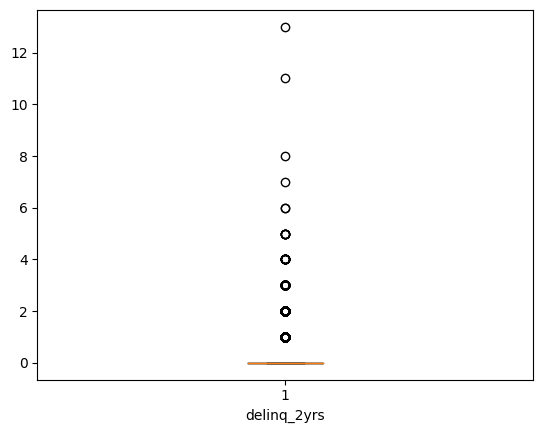

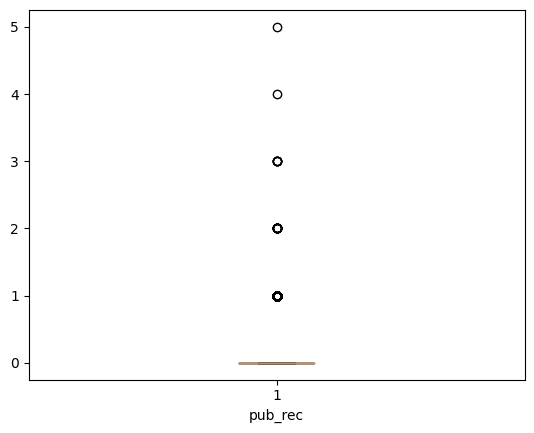

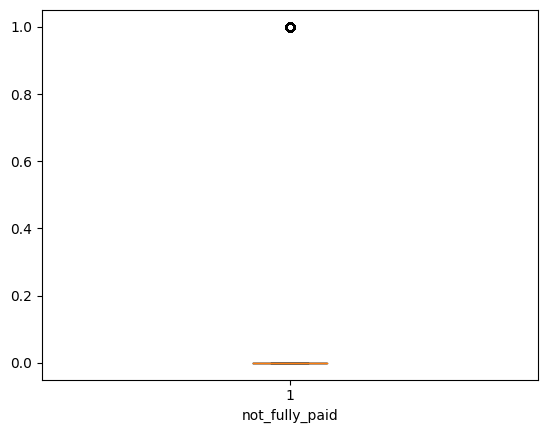

In [11]:
# Box Plots for numerical features

numeric_columns = loans.select_dtypes(include=['float', 'int']).columns
for col in numeric_columns:
    plt.figure()
    plt.xlabel(col)
    plt.boxplot(loans[col])

The log.annual.inc column has outliers on both the lower and upper fences. It might be due to having borrowers of both very low and very high incomes applying for loans. We also have a few outliers on the upper fence of fico, int.rate and installment features.

We understand that removing or replacing outliers requires a lot of care and domain knowledge. This time, we'll try to adjust the log.annual.inc outliers for modeling by replacing them with their upper and lower bounds. The rest of the outliers represent natural variations in the population, and we will leave them as they are in the data set.

In [12]:
# Finding the upper and lower limit for some of the features

def find_outlier_limits(col_name):
    Q1,Q3=loans[col_name].quantile([.25,.75])
    IQR=Q3-Q1
    low=Q1-(1.5* IQR)
    high=Q3+(1.5* IQR)
    return (high,low)

high_log_annual_inc, low_log_annual_inc = find_outlier_limits('log_annual_inc')
print('Log Annual Income: ','upper limit: ',high_log_annual_inc,' lower limit: ',low_log_annual_inc)

Log Annual Income:  upper limit:  12.39061201375  lower limit:  9.45909442375


In [13]:
# Replacing outlier values for log_annual_inc, and installment with respective upper and lower limits 
loans.loc[loans['log_annual_inc'] > high_log_annual_inc,'log_annual_inc'] = high_log_annual_inc
loans.loc[loans['log_annual_inc'] < low_log_annual_inc,'log_annual_inc'] = low_log_annual_inc

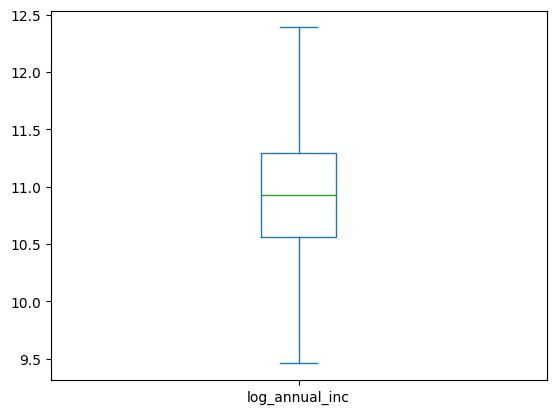

In [14]:
# Check with box plot for log.annual.income and installment if the outliers were replaced
loans['log_annual_inc'].plot(kind='box');

## II. Split Data

In [15]:
target = 'not_fully_paid'

y = loans[target] # target vector
X = loans.drop(columns=target) # feature matrix

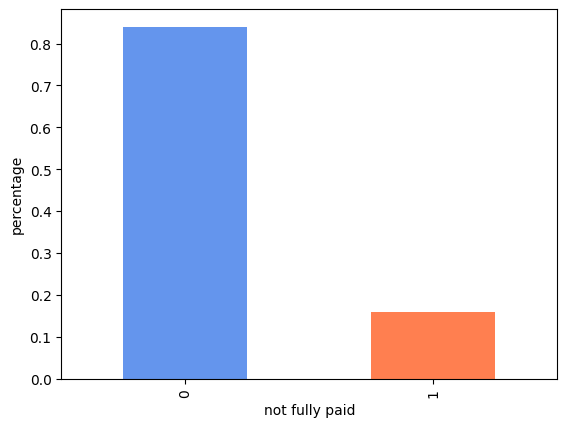

In [16]:
# Let's take a look at the distribution of the target column.

# Percentage
y.value_counts(normalize=True).plot(kind='bar', color=['cornflowerblue', 'coral'])
plt.xlabel('not fully paid')
plt.ylabel('percentage');

The graph shows our target has a binary class, which are default and paid in full loans. This is a good illustration of the class imbalance of our classification target. Close to 84% of the examples were labeled as  0 (fully paid) and about 16% of the examples were labeled as 1 (not fully paid).


In [17]:
# Randomly split data into remain and test sets
X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
# Create a training set and validation set from the remaining data
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, test_size= 0.2, random_state = 42)

Since we have a severe imbalance problem, we need to re-balance our data using synthetic minority oversampling technique for nominal and continuous (SMOTENC) data. This technique is for data sets containing numerical and categorical features. It uses characteristics of nearest neighbors of minority class examples to replicate new ones that are quite similar to the existing observations in the minority class.  

## III. SMOTENC for Sampling of Numerical and Categorical Imbalanced Data

In [19]:
method = SMOTENC(random_state=42, categorical_features= [1,2])
X_train_res, y_train_res = method.fit_resample(X_train, y_train)

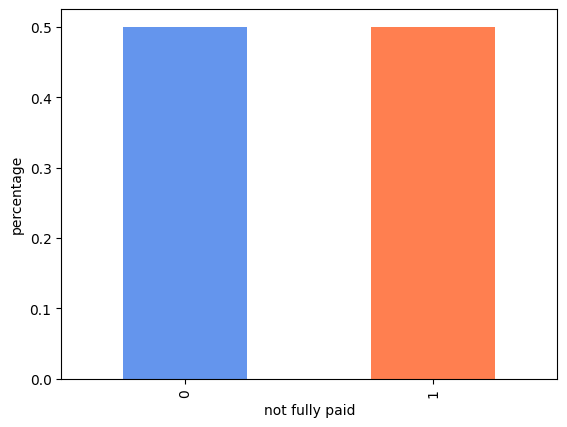

In [20]:
# Let's take a look at the distribution of the target after applying SMOTENC.

# Percentage
y_train_res.value_counts(normalize=True).plot(kind='bar', color=['cornflowerblue', 'coral'])
plt.xlabel('not fully paid')
plt.ylabel('percentage');

The SMOTENC technique has oversampled the minority instances and made it equal to the majority class. Now, both categories have equal number of examples. In other words, the minority class has been increased to the total number of majority class. 

## IV. Establish Baseline

In [21]:
 print('Baseline accuracy - imbalanced data:', y_train.value_counts(normalize=True).max())

Baseline accuracy - imbalanced data: 0.8350465002447381


In [22]:
 print('Baseline accuracy - balanced data:', y_train_res.value_counts(normalize=True).max())

Baseline accuracy - balanced data: 0.5


## V. Build Model

In [23]:
# Model 1 : Logistic Regression - Imbalanced Data

model_lr = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(), 
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [24]:
# Model 2 : Random Forest - Imbalanced Data

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs= -1)
)

model_rf.fit(X_train, y_train);

In [25]:
# Model 3 : Logistic Regression - Balanced Data

model_lr_res = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(), 
    StandardScaler(),
    LogisticRegression()
)

model_lr_res.fit(X_train_res, y_train_res);

/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [26]:
# Model 4 : Random Forest - Balanced Data

model_rf_res = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs= -1)
)

model_rf_res.fit(X_train_res, y_train_res);

---

**Predicting using the models for binary classification**

In [27]:
y_pred_lr = model_lr.predict(X_val)
y_pred_rf = model_rf.predict(X_val)

y_pred_lr_res = model_lr_res.predict(X_val)
y_pred_rf_res = model_rf_res.predict(X_val)

## VI. Check Metrics

### Accuracy before SMOTENC

In [28]:
print('Training Accuracy (LOGR) Imbalanced Data:', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR) Imbalanced Data:', model_lr.score(X_val, y_val))

Training Accuracy (LOGR) Imbalanced Data: 0.8352096589982052
Validation Accuracy (LOGR) Imbalanced Data: 0.8571428571428571


In [29]:
print('Training Accuracy (RF) Imbalanced Data:', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF) Imbalanced Data:', model_rf.score(X_val, y_val))

Training Accuracy (RF) Imbalanced Data: 1.0
Validation Accuracy (RF) Imbalanced Data: 0.8590998043052838


It seems like the accuracy of both models is higher than the baseline. For the RF model the training accuracy is perfect but it doesn't generalize as well to the validation set.

At a glance, the RF model would be a good choice. But since we have imbalanced data, this high value in this metric can lead to erroneous evaluation. In this case, it's better to use other metrics such as precision and recall to help us know where the model went wrong. 

Let's see how the accuracy changes once we even out the classes in our target feature.

### Accuracy after SMOTENC

In [30]:
print('Training Accuracy (LOGR) Balanced Data:', model_lr_res.score(X_train_res, y_train_res))
print('Validation Accuracy (LOGR) Balanced Data:', model_lr_res.score(X_val, y_val))

Training Accuracy (LOGR) Balanced Data: 0.6759476357952325
Validation Accuracy (LOGR) Balanced Data: 0.6757990867579908


In [31]:
print('Training Accuracy (RF) Balanced Data:', model_rf_res.score(X_train_res, y_train_res))
print('Validation Accuracy (RF) Balanced Data:', model_rf_res.score(X_val, y_val))

Training Accuracy (RF) Balanced Data: 1.0
Validation Accuracy (RF) Balanced Data: 0.7540769732550554


After balancing the data, the LOGR model experienced a reduction in both training and validation accuracy scores. On the other hand, the RF model kept the same perfect training accuracy score and the validation accuracy score decreased by some points.

### Precision, Recall, F1

LOGISTIC REGRESSION - Imbalanced Data
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1316
           1       0.44      0.03      0.06       217

    accuracy                           0.86      1533
   macro avg       0.65      0.51      0.49      1533
weighted avg       0.80      0.86      0.80      1533



/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


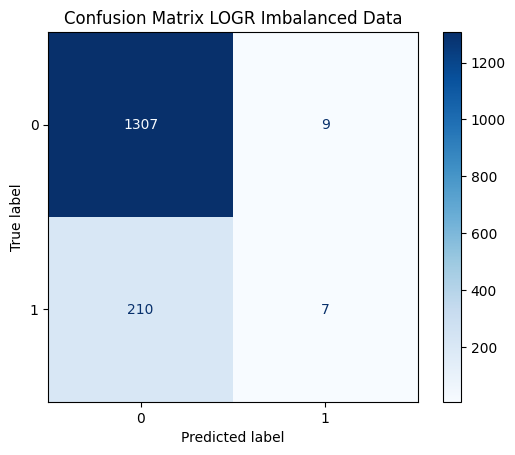

In [32]:
print('LOGISTIC REGRESSION - Imbalanced Data')
print(classification_report(y_val, y_pred_lr));

plot_confusion_matrix(model_lr, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix LOGR Imbalanced Data');

When the data is imbalanced, the LOGR model predictions about loans that were not fully paid were correct 44% of the times (precision) but this model correctly classified only 3% of the default loans (recall).  

LOGISTIC REGRESSION - Balanced Data
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1316
           1       0.20      0.43      0.27       217

    accuracy                           0.68      1533
   macro avg       0.54      0.57      0.53      1533
weighted avg       0.79      0.68      0.72      1533



/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


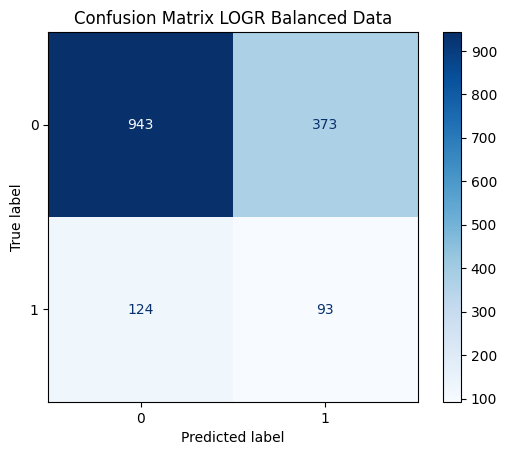

In [33]:
print('LOGISTIC REGRESSION - Balanced Data')
print(classification_report(y_val, y_pred_lr_res));
plot_confusion_matrix(model_lr_res, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix LOGR Balanced Data');

After balancing the data, the LOGR predictions about loans that were not fully paid were correct 20% of the times (precision). This model correctly classified 43% of the default loans (recall). We can see improvements here!

RANDOM FOREST - Imbalanced Data
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1316
           1       0.57      0.02      0.04       217

    accuracy                           0.86      1533
   macro avg       0.72      0.51      0.48      1533
weighted avg       0.82      0.86      0.80      1533



/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


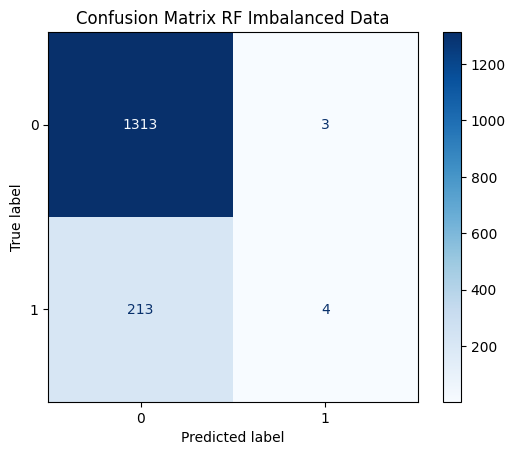

In [34]:
print('RANDOM FOREST - Imbalanced Data')
print(classification_report(y_val, y_pred_rf));
plot_confusion_matrix(model_rf, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix RF Imbalanced Data');

When the data was imbalanced, the RF model predictions about loans that were not fully paid were correct 57% of the times (precision). However, this model correctly classified only 2% of the default loans (recall).

RANDOM FOREST - Balanced Data
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1316
           1       0.17      0.20      0.19       217

    accuracy                           0.75      1533
   macro avg       0.52      0.52      0.52      1533
weighted avg       0.77      0.75      0.76      1533



/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


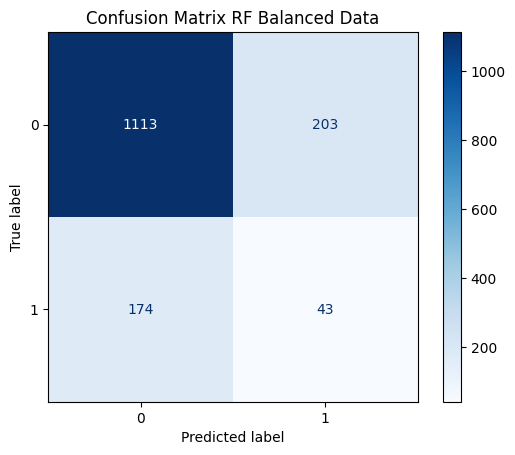

In [35]:
print('RANDOM FOREST - Balanced Data')
print(classification_report(y_val, y_pred_rf_res));
plot_confusion_matrix(model_rf_res, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix RF Balanced Data');

After balancing the data, the RF model predictions about loans that were not fully paid, were correct 17% of the times (precision).The model correctly classified 20% of the default loans (recall). 

/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecatio

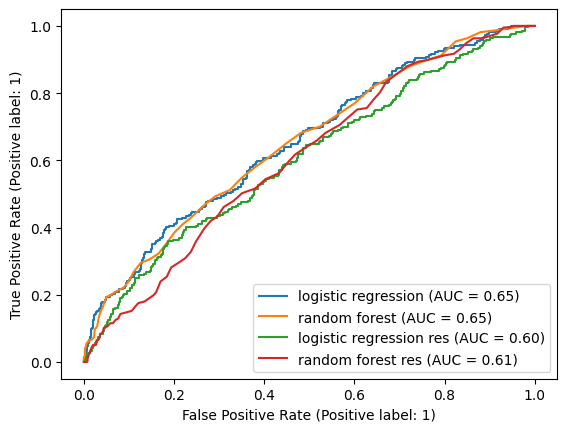

In [36]:
# Plot the ROC Curve

lr = plot_roc_curve(
    model_lr, 
    X_val,
    y_val, 
    name= 'logistic regression')

rf = plot_roc_curve(
    model_rf, 
    X_val,
    y_val, 
    ax=lr.ax_,
    name= 'random forest')

lr_res = plot_roc_curve(
    model_lr_res, 
    X_val,
    y_val,
    ax=lr.ax_,
    name= 'logistic regression res')

rf_res = plot_roc_curve(
    model_rf_res, 
    X_val,
    y_val, 
    ax=lr.ax_,
    name= 'random forest res')

In [38]:
print('ROC AUC Score for LOGR imbalanced data:', roc_auc_score(y_val, model_lr.predict_proba(X_val)[:, -1]))
print('ROC AUC Score for LOGR balanced data:', roc_auc_score(y_val, model_lr_res.predict_proba(X_val)[:, -1]))
print('')
print('ROC AUC Score for RF imbalanced data:', roc_auc_score(y_val, model_rf.predict_proba(X_val)[:, -1]))
print('ROC AUC Score for RF balanced data:', roc_auc_score(y_val, model_rf_res.predict_proba(X_val)[:, -1]))

ROC AUC Score for LOGR imbalanced data: 0.6533028448167187
ROC AUC Score for LOGR balanced data: 0.6041663748546777

ROC AUC Score for RF imbalanced data: 0.6506257616292915
ROC AUC Score for RF balanced data: 0.6063724734917989


The accuracy for both models before balancing the data is better for LOGR model (65.33%) compared to the score for RF (63.98%). But the recall of the minority class for both of them is very low: 3% LOGR and 2% for RF. It proves that both models are more biased towards the majority class. That's the reason why we applied the SMOTENC technique.

After applying SMOTENC technique, it seems like the RF model has a better performance for prediction when compared to the LOGR model. The RF score is 60.64% and LOGR score is 60.42. However, recall is better in the LOGR model (43%) compared to RF (20%).

Since investors don't want to lose money, it is a good idea to alert them even if there is a slight doubt a borrower might be a defaulter. For this reason, we would prefer to use the model that has higher recall rates. In this case, the LOGR after being balanced.

Test Accuracy (LOGR) Balanced Data: 0.6816283924843424
Random Forest Balanced Data
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1611
           1       0.25      0.50      0.33       305

    accuracy                           0.68      1916
   macro avg       0.57      0.61      0.56      1916
weighted avg       0.78      0.68      0.72      1916



/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


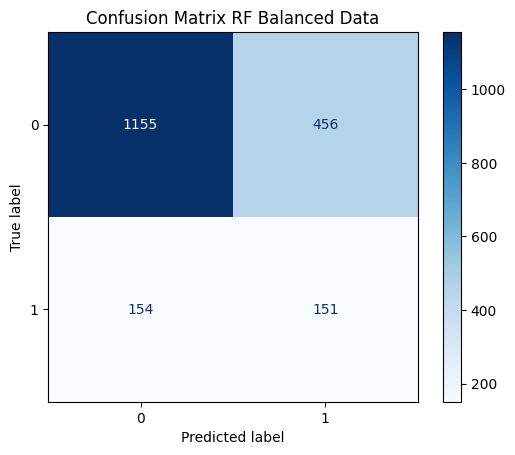

In [39]:
# Evaluating the LOGR - balanced model on the test set

print('Test Accuracy (LOGR) Balanced Data:', model_lr_res.score(X_test, y_test))
print('Random Forest Balanced Data')
print(classification_report(y_test, model_lr_res.predict(X_test)));
plot_confusion_matrix(model_lr_res, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix RF Balanced Data');

In [40]:
print('ROC AUC Score for LOGR balanced data:', roc_auc_score(y_test, model_lr_res.predict_proba(X_test)[:, -1]))

ROC AUC Score for LOGR balanced data: 0.6570178384263923


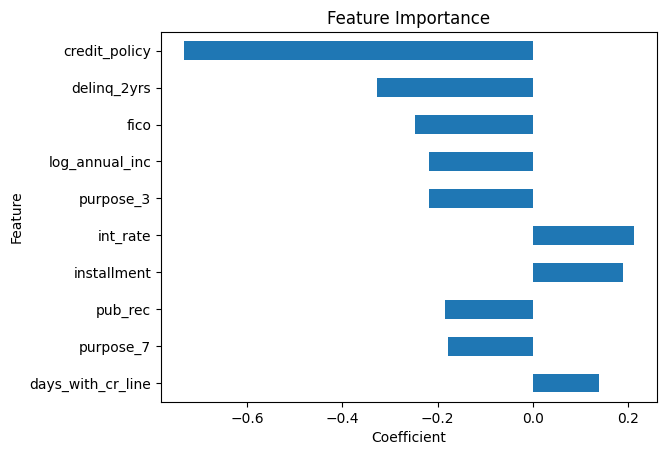

In [41]:
# Plotting feature importances
features = model_lr_res.named_steps['onehotencoder'].get_feature_names()
coefficients = model_lr_res.named_steps['logisticregression'].coef_[0]
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance');